## lncRNA DEG, CoxPH
---
* cBioPortal clinical data
* TARNIC lncRNA data

In [62]:
import statistics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
from scipy import stats
from scipy.stats import spearmanr
import math
pd.set_option('display.max_columns', 500)

import mygene
mg = mygene.MyGeneInfo()

import rpy2.rinterface
#ipython extension
%load_ext rpy2.ipython
from rpy2.robjects import pandas2ri
pandas2ri.activate()

%R library(limma)

from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
cph = CoxPHFitter()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
#gene query func.
def genequery(target):
    #ENSG00000226179.10 to ENSG00000226179
    for i in range(len(target['Unnamed: 0'])):
        try:
            target['Unnamed: 0'][i] = target['Unnamed: 0'][i].split('.')[0]
        except:
            pass

    #gene query
    ens = target['Unnamed: 0']
    ginfo = mg.querymany(ens, scopes='ensembl.gene')

    #symbol add
    target['symbol'] = 0
    target = target.reset_index()

    for i in range(len(ginfo)):
        try:
            target['symbol'][i] = ginfo[i]['symbol']
        except:
            target['symbol'][i] = target['Unnamed: 0'][i]
            
    return target

In [3]:
#DEG cutoff func.
pval = 0.05
logfc = 0

def degpl(deg):
    m = deg['adj.P.Val'] < pval
    m_pl = deg['logFC'] > logfc
    
    deg_pl = deg[m][m_pl]
    deg_pl = deg_pl.dropna(axis=0)
    try:
        deg_pl = deg_pl.drop_duplicates(['ID'])
    except:
        deg_pl = deg_pl.drop_duplicates(['Unnamed: 0'])
    print('deg_pl: ', deg_pl.shape)
    return deg_pl

def degmi(deg):
    m = deg['adj.P.Val'] < pval
    m_mi = deg['logFC'] < -logfc
    
    deg_mi = deg[m][m_mi]
    deg_mi = deg_mi.dropna(axis=0)
    try:
        deg_mi = deg_mi.drop_duplicates(['ID'])
    except:
        deg_mi = deg_mi.drop_duplicates(['Unnamed: 0'])
    print('deg_mi: ', deg_mi.shape)
    return deg_mi

In [144]:
table = pd.read_csv('./data_bcr_clinical_data_patient.txt', sep='\t')

lncrna = pd.read_csv('./TCGA-HNSC-rnaexpr/TCGA-HNSC-rnaexpr.tsv', sep='\t', header=None).T

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249

In [145]:
#table2 <<< OSCC clinical data
table['OSCC'] = table['Patient Primary Tumor Site'].apply(lambda x: True 
                                                          if x in ['Lip', 'Oral Tongue', 'Floor of mouth', 'Buccal Mucosa', 'Hard Palate', 'Oropharynx', 'Oral Cavity', 'Tonsil'] 
                                                          else False)

table2 = table[table['OSCC'] == True]

In [146]:
#masking tumor sample
m = lncrna[0].str.contains('Tumor') | lncrna[0].str.contains('Gene_ID')

lncrna2 = lncrna[m]

In [147]:
#HNSC-Normal-TCGA-CV-6934 >>> TCGA-CV-6934
lncrna2[0] = lncrna2[0].apply(lambda x: ('-'.join(x.split('-')[2:])))

lncrna2.columns = lncrna2.loc[0]

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [148]:
#merge
table3 = pd.merge(table2, lncrna2, left_on = 'Patient Identifier', right_on = '')

table3.to_csv('./TCGA_lncrna.csv', index=False)

In [149]:
#pset/eset
table4 = table3.loc[:, (table3 != 0).any(axis=0)]

pset = table4.loc[:,:'Disease Free (Months)']

eset = table4.loc[:,'ENSG00000005206.12':]

eset.to_csv('./eset.csv', index=False)
eset = pd.read_csv('./eset.csv')

pset.to_csv('./pset.csv')
eset.to_csv('./eset.csv')

---
## CoxPH

In [65]:
eset = np.log2(eset+1)

target = table4[['Overall Survival Status', 'Overall Survival (Months)']].reset_index(drop=True)

target = pd.concat([target, eset], axis=1)

target = target.replace('[Not Available]', np.NaN)
target = target.replace('0:LIVING', 0)
target = target.replace('1:DECEASED', 1)

target = target.dropna(axis=0)

for i in range(2,len(target.columns)):
    target.iloc[:,i] = target.iloc[:,i] > statistics.median(target.iloc[:,i])

target.to_csv('./cox_eset.csv', index=False)

In [67]:
target = pd.read_csv('./cox_eset.csv')

In [16]:
temp2 = pd.DataFrame()
for i in range(2,len(target.columns)):
    try:
        temp = cph.fit(target.iloc[:,[0,1,i]], duration_col='Overall Survival (Months)', event_col='Overall Survival Status')
        temp2=temp2.append(temp.summary)
    except:
        pass

temp2.to_csv('./cox.csv')

In [68]:
temp2 = pd.read_csv('./cox.csv', index_col=0)

In [69]:
m = temp2['p'] < 0.001
temp2 = temp2[m]

In [70]:
temp2['Unnamed: 0'] = temp2.index

query = genequery(temp2)

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


querying 1-10...done.
Finished.


C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [71]:
#for seaborn pointplot
temp3 = query.loc[:,'upper 0.95':'symbol']
temp3.columns = ['lower 0.95', 'Unnamer: 0', 'symbol']
temp4 = query.append(temp3)

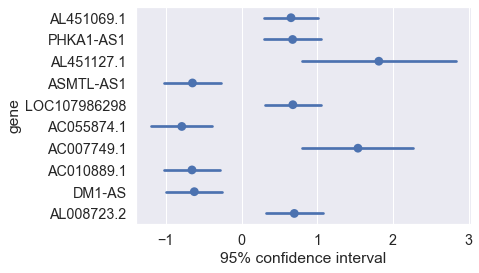

In [78]:
ax = sns.pointplot(x="lower 0.95", y="symbol", data=temp4, join=False)
plt.ylabel('gene')
plt.xlabel('95% confidence interval')
plt.savefig('./cox_forest_plot.png', dpi=300, bbox_inches='tight')

---
## Survival analysis

In [85]:
target2 = target.copy()
temp2 = pd.DataFrame()
for i in range(2,len(target.columns)):
    try:
        target2.iloc[:,i] = target.iloc[:,i] > target.iloc[:,i].median()
        temp = cph.fit(target2.iloc[:,[0,1,i]], duration_col='Overall Survival (Months)', event_col='Overall Survival Status')
        result = proportional_hazard_test(cph, target2.iloc[:,[0,1,i]], time_transform='rank')
        temp2=temp2.append(result.summary)
    except:
        pass

temp2.to_csv('./surv.csv')

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:666: RuntimeWarning: divide by zero encountered in true_divide
  denom = 1.0 / np.array([risk_phi])
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:668: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:670: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:660: RuntimeWarning: divide by zero encountered in true_divide
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:663: RuntimeWarning: invalid value encountered in multiply
  "ab,i->ab", tie_phi_x_x, increasing_proportion * denom
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\lif

In [138]:
temp2 = pd.read_csv('./surv.csv')

In [139]:
m = temp2['p'] < 0.001

temp2 = temp2[m]

In [140]:
temp2 = genequery(temp2)
temp2 = genequery(temp2)
temp2.index = temp2['symbol']

querying 1-16...done.
Finished.
16 input query terms found no hit:
	['ENSG00000223823.1', 'ENSG00000223882.1', 'ENSG00000229666.1', 'ENSG00000233220.3', 'ENSG0000023413
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-16...

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


done.
Finished.
1 input query terms found no hit:
	['ENSG00000258280']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [152]:
target = table4[['Overall Survival Status', 'Overall Survival (Months)']].reset_index(drop=True)

target = pd.concat([target, eset], axis=1)

target = target.replace('[Not Available]', np.NaN)
target = target.replace('0:LIVING', 0)
target = target.replace('1:DECEASED', 1)

target = target.dropna(axis=0)

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\lifelines\utils\__init__.py:974: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetime_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text)
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\lifelines\utils\__init__.py:974: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetime_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text)
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\lifelines\utils\__init__.py:974: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetime_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text)
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\lifelines\utils\

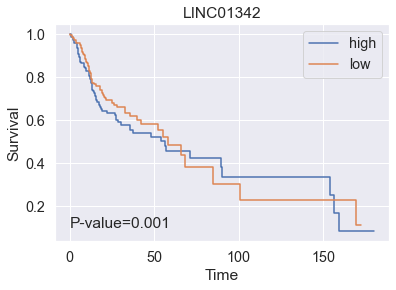

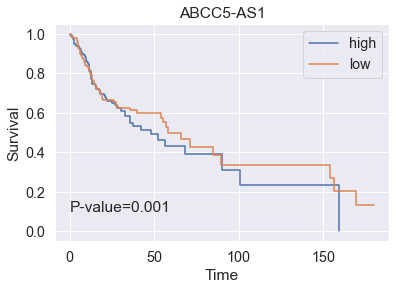

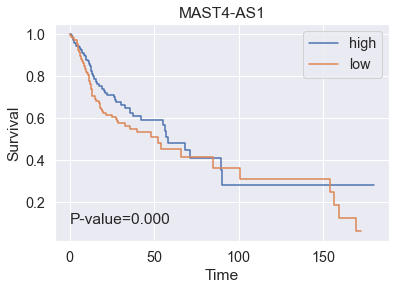

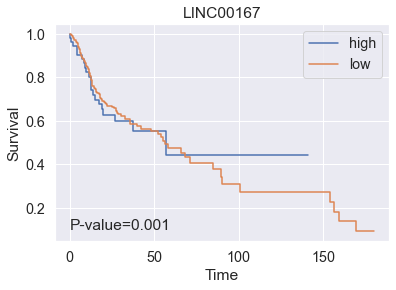

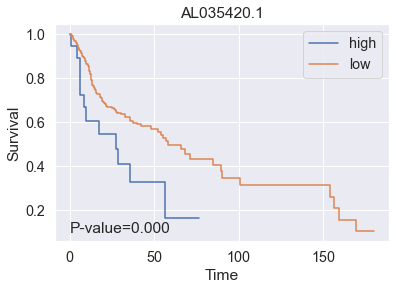

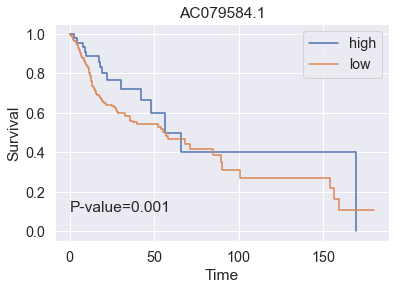

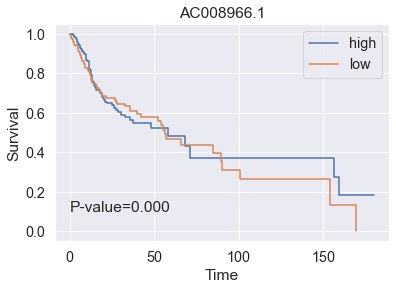

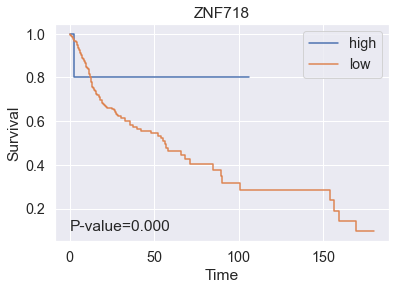

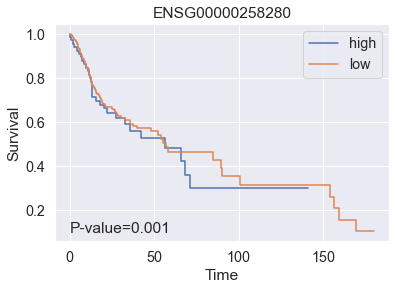

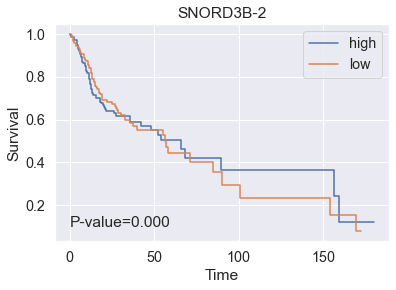

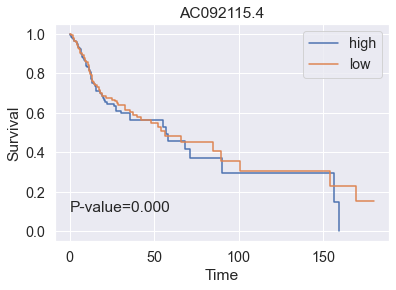

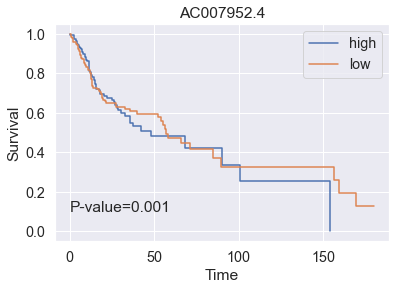

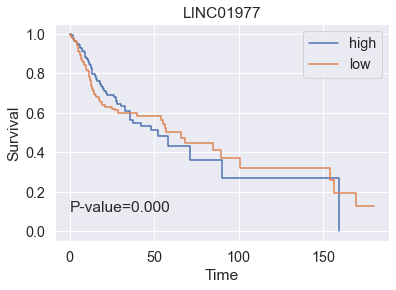

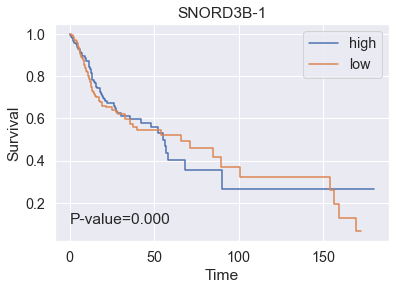

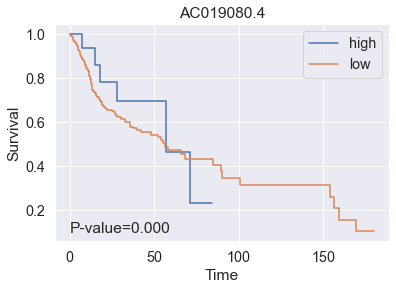

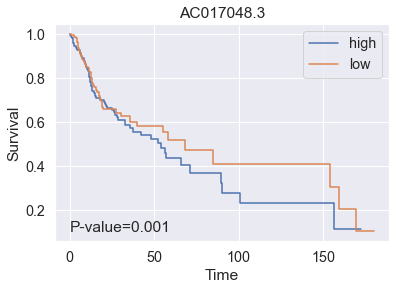

In [168]:
j=0
for i in (temp2['index']):
    mask = target.iloc[:,i] > target.iloc[:,i].median()
    kmf.fit(target['Overall Survival (Months)'][mask], target['Overall Survival Status'][mask], label='high')
    ax = kmf.plot(ci_show=False)

    mask2 = target.iloc[:,i] <= target.iloc[:,i].median()
    kmf.fit(target['Overall Survival (Months)'][mask2], target['Overall Survival Status'][mask2], label='low')
    kmf.plot(ax=ax, ci_show=False)
    
    ax.text(0,0.1,'P-value=%.3f'% temp2['p'][j])    
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Survival')
    ax.set_title('%s' %temp2.iloc[j][-1])
    plt.savefig('./survival_%s.png' %temp2.iloc[j][-1], dpi=300, bbox_inches='tight')
    j+=1

---
## DEG

In [82]:
%%R
eset = read.csv('./eset.csv', row.names='X')
#del zero col
eset = eset[, colSums(eset != 0) > 0]
eset = t(eset)
#log2 transformation
eset = log2(eset+1)

pset = read.csv('./pset.csv', row.names='X')

In [84]:
%%R
#stage DEG

design = data.frame(pset['Neoplasm.Disease.Stage.American.Joint.Committee.on.Cancer.Code'] == 'Stage I' | pset['Neoplasm.Disease.Stage.American.Joint.Committee.on.Cancer.Code'] == 'Stage II',
  pset['Neoplasm.Disease.Stage.American.Joint.Committee.on.Cancer.Code'] == 'Stage III' | pset['Neoplasm.Disease.Stage.American.Joint.Committee.on.Cancer.Code'] == 'Stage IVA' | pset['Neoplasm.Disease.Stage.American.Joint.Committee.on.Cancer.Code'] == 'Stage IVB')
colnames(design) <- c("Stage12","Stage34")

design = data.matrix(design)

#fit
fit <- lmFit(eset,design)
cont <- makeContrasts(Stage34-Stage12,levels=design)
fit.cont <- contrasts.fit(fit,cont)
fit.cont <- eBayes(fit.cont)
res <- topTable(fit.cont,number=Inf)

write.csv(res, './stage_limma.csv')

In [85]:
%%R
#LN DEG

design = data.frame(pset['Neoplasm.Disease.Lymph.Node.Stage.American.Joint.Committee.on.Cancer.Code'] == 'N0',
                    pset['Neoplasm.Disease.Lymph.Node.Stage.American.Joint.Committee.on.Cancer.Code'] == 'N1'
                   | pset['Neoplasm.Disease.Lymph.Node.Stage.American.Joint.Committee.on.Cancer.Code'] == 'N2'
                   | pset['Neoplasm.Disease.Lymph.Node.Stage.American.Joint.Committee.on.Cancer.Code'] == 'N2a'
                   | pset['Neoplasm.Disease.Lymph.Node.Stage.American.Joint.Committee.on.Cancer.Code'] == 'N2b'
                   | pset['Neoplasm.Disease.Lymph.Node.Stage.American.Joint.Committee.on.Cancer.Code'] == 'N3')
colnames(design) <- c("NO","YES")

design = data.matrix(design)

#fit
fit <- lmFit(eset,design)
cont <- makeContrasts(YES-NO,levels=design)
fit.cont <- contrasts.fit(fit,cont)
fit.cont <- eBayes(fit.cont)
res <- topTable(fit.cont,number=Inf)

write.csv(res, './ln_limma.csv')

In [86]:
%%R
#histopathologic DEG

design = data.frame(pset['Neoplasm.Histologic.Grade'] == 'G1'
                    | pset['Neoplasm.Histologic.Grade'] == 'G2',
                    pset['Neoplasm.Histologic.Grade'] == 'G3'
                    | pset['Neoplasm.Histologic.Grade'] == 'G4')
colnames(design) <- c("LOW","HIGH")

design = data.matrix(design)

#fit
fit <- lmFit(eset,design)
cont <- makeContrasts(HIGH-LOW,levels=design)
fit.cont <- contrasts.fit(fit,cont)
fit.cont <- eBayes(fit.cont)
res <- topTable(fit.cont,number=Inf)

write.csv(res, './histopathologic_limma.csv')

---
## plot

In [87]:
pval = 0.05
logfc = 0

def plotprocess():
    res['logPV'] = res['adj.P.Val'].apply(lambda x: -(math.log10(x)))

    res['type'] = 'etc'

    for i in res.index:
        if res.at[i, 'adj.P.Val'] < pval:
            if res.at[i, 'logFC'] > logfc:
                res.at[i, 'type'] = 'pl'
            elif res.at[i, 'logFC'] < -logfc:
                res.at[i, 'type'] = 'mi'

Text(0, 0.5, '${-log_{10}}$ FDR')

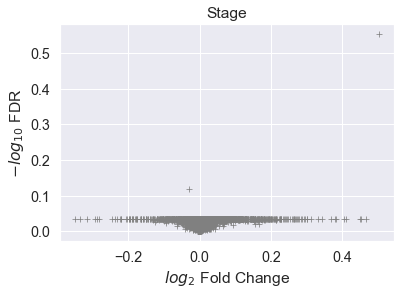

In [89]:
res = pd.read_csv('./stage_limma.csv')
plotprocess()

f1 = sns.scatterplot('logFC', 'logPV', marker='+', hue='type', data = res, palette = {'mi':'green', 'pl':'red', 'etc':'gray'}, legend = False)
# f1.vlines (1, 0, 9, colors = 'black')
# f1.vlines (-1, 0, 9, colors = 'black')
# f1.hlines (-(math.log10(0.05)), -20, 20, colors = 'black')
# axes = f1.axes
# f1.set_xlim(-20,20)
# f1.set_ylim(0, 6.5)

plt.title('Stage')
plt.xlabel('${log_{2}}$ Fold Change')
plt.ylabel('${-log_{10}}$ FDR')

#plt.savefig('./volcano_gse28460.png', dpi=300)

Text(0, 0.5, '${-log_{10}}$ FDR')

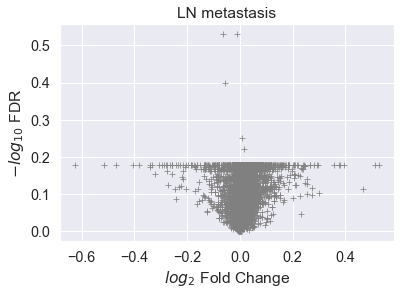

In [90]:
res = pd.read_csv('./ln_limma.csv')
plotprocess()

f1 = sns.scatterplot('logFC', 'logPV', marker='+', hue='type', data = res, palette = {'mi':'green', 'pl':'red', 'etc':'gray'}, legend = False)
# f1.vlines (1, 0, 9, colors = 'black')
# f1.vlines (-1, 0, 9, colors = 'black')
# f1.hlines (-(math.log10(0.05)), -20, 20, colors = 'black')
# axes = f1.axes
# f1.set_xlim(-20,20)
# f1.set_ylim(0, 6.5)

plt.title('LN metastasis')
plt.xlabel('${log_{2}}$ Fold Change')
plt.ylabel('${-log_{10}}$ FDR')

#plt.savefig('./volcano_gse28460.png', dpi=300)

Text(0, 0.5, '${-log_{10}}$ FDR')

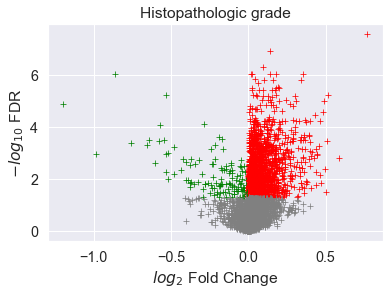

In [91]:
res = pd.read_csv('./histopathologic_limma.csv')
plotprocess()

f1 = sns.scatterplot('logFC', 'logPV', marker='+', hue='type', data = res, palette = {'mi':'green', 'pl':'red', 'etc':'gray'}, legend = False)
# f1.vlines (1, 0, 9, colors = 'black')
# f1.vlines (-1, 0, 9, colors = 'black')
# f1.hlines (-(math.log10(0.05)), -20, 20, colors = 'black')
# axes = f1.axes
# f1.set_xlim(-20,20)
# f1.set_ylim(0, 6.5)

plt.title('Histopathologic grade')
plt.xlabel('${log_{2}}$ Fold Change')
plt.ylabel('${-log_{10}}$ FDR')

#plt.savefig('./volcano_gse28460.png', dpi=300)

---
## DEG cutoff & gene query

In [94]:
survival = pd.read_csv('./survival_limma.csv')

In [95]:
survival_pl = degpl(survival)
survival_mi = degmi(survival)

deg_pl:  (0, 7)
deg_mi:  (0, 7)


C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [96]:
stage = pd.read_csv('./stage_limma.csv')

In [97]:
stage_pl = degpl(stage)
stage_mi = degmi(stage)

deg_pl:  (0, 7)
deg_mi:  (0, 7)


C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [98]:
ln = pd.read_csv('./ln_limma.csv')

In [99]:
ln_pl = degpl(ln)
ln_mi = degmi(ln)

deg_pl:  (0, 7)
deg_mi:  (0, 7)


C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [100]:
histopathologic = pd.read_csv('./histopathologic_limma.csv')

In [101]:
histopathologic_pl = degpl(histopathologic)
histopathologic_mi = degmi(histopathologic)

deg_pl:  (1972, 7)
deg_mi:  (129, 7)


C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [102]:
histopathologic_pl = genequery(histopathologic_pl)

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


querying 1-1000...done.
querying 1001-1972...done.
Finished.
275 input query terms found no hit:
	['ENSG00000271782', 'ENSG00000272301', 'ENSG00000270018', 'ENSG00000270173', 'ENSG00000261252', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [103]:
histopathologic_mi = genequery(histopathologic_mi)

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


querying 1-129...done.
Finished.
125 input query terms found no hit:
	['ENSG00000261521', 'ENSG00000236996.1', 'ENSG00000246740.2', 'ENSG00000224984.1', 'ENSG00000261068.
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [104]:
histopathologic_pl.to_csv('./histopathologic_up.csv', index = False)
histopathologic_mi.to_csv('./histopathologic_dn.csv', index = False)